In [1]:

import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *



processGens=ProcessGens()
processGens.init_with_mode("full_sample")
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics = processGens.get_params()


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode full_sample
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

In [2]:

from process_gen_utils import *
print(f"sum(num_beams_list) {sum(num_beams_list)}")
examples_df, completions_df=get_dfs(processGens, num_beams_list)

# for df in examples_df, completions_df:
examples_df=examples_df.rename(columns={"example_comet": "comet_score"})
completions_df=completions_df.rename(columns={"example_comet": "comet_score"})

print(examples_df.head(2))

sum(num_beams_list) 1
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'text', 'completion_length', 'output_logprob', 'instanceID',
       'isCompletion', 'BLEU_1', 'BLEU_4'],
      dtype='object')
Num examples: 10000
Num completions: 100
   comet_score  beam_num  task_name  model  example_idx  \
0     0.753509         1          0      0            0   
1     0.816450         1          0      0            1   

                                                text  completion_length  \
0  He advised the parents of a boy whose penis ha...                215   
1  He advised the parents of a boy whose penis ha...                184   

   output_logprob instanceID isCompletion    BLEU_1    BLEU_4  
0      -23.538330    id24245         True  0.678542  0.380233  
1      -26.494779    id24245         None  0.684211  0.428571  


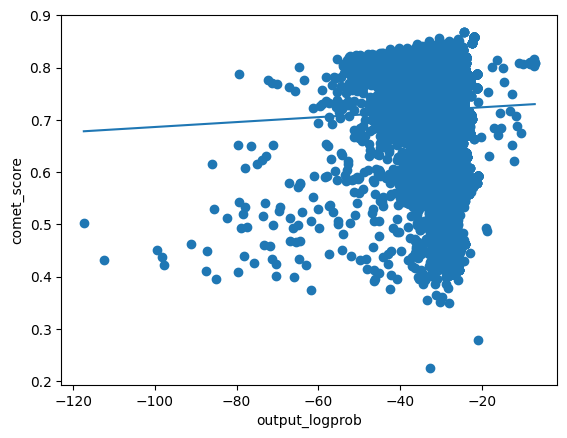

In [3]:
# examples_df
plot_keys(df=examples_df, xlabel='output_logprob', ylabel='comet_score')

In [4]:
for col in ['comet_score', 'output_logprob']:
    examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

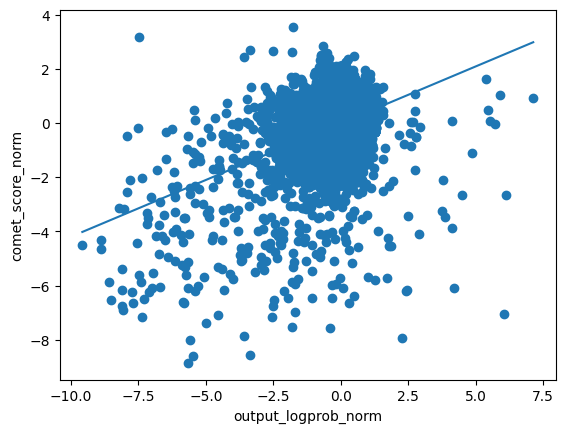

In [5]:
plot_keys(df=examples_df, xlabel='output_logprob_norm', ylabel='comet_score_norm')


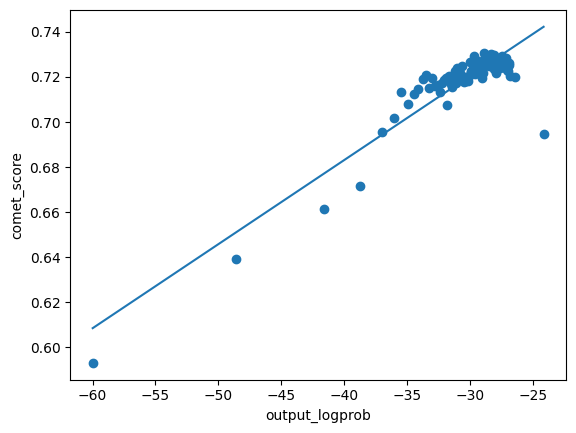

In [6]:
grouped_df = examples_df[["example_idx", "comet_score", "output_logprob"]].groupby('example_idx').mean()

grouped_df.head(2)

plot_keys(grouped_df, "output_logprob", "comet_score")